# Investigating Transfer Learning from German to U.S. Traffic Signs

This notebook demonstrates how to load an ImageNet-pretrained ResNet50 model and investigate transfer learning by pre-training the model on a traffic-sign dataset from one country and fine-tuning it to predict traffic signs from another country, using the German-to-U.S. scenario as a case study.

## Datasets
German Traffic Signs (German Traffic Sign Recognition Benchmark GTSRB):
J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011.

U.S. Traffic Signs (LISA Traffic Sign Dataset):
Andreas Møgelmose, Mohan M. Trivedi, and Thomas B. Moeslund, “Vision based Traffic Sign Detection and Analysis for Intelligent Driver Assistance Systems: Perspectives and Survey,” IEEE Transactions on Intelligent Transportation Systems, 2012.

In [1]:
!pip install requests pandas numpy matplotlib pillow torch torchvision

In [2]:
from lisa import LISA # local file

import os
import requests
import zipfile
import copy
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.models import ResNet50_Weights, resnet50
from torchvision.datasets import GTSRB
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

/dccstor/uhistore/TrafficSignTransferLearning/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


The random seed is set to ensure reproducibility of results. The computation device (CPU or GPU) is specified accordingly, and any required directories are created if they do not already exist.

In [3]:
# for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# create directories if they do not already exist
os.makedirs("data", exist_ok=True)
os.makedirs("model", exist_ok=True)

cuda


A pre-trained ResNet-50 model is loaded using weights derived from ImageNet. The model's parameters are then saved for subsequent use.

In [4]:
base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
base_model.eval()

# save the model weights
torch.save(base_model.state_dict(), "model/resnet50_imagenet_weights.pth")
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The GTSRB dataset is loaded and preprocessed using standard data augmentation techniques and normalization to enhance generalization and model performance.

**Note:** 
The `download` flag should be set to `True` during the initial execution to automatically retrieve the dataset and store it in the specified `root` directory.  
For subsequent runs, setting `download=False` prevents redundant downloads by utilizing the locally stored copy.

In [5]:
# 43 GTSRB class labels (https://benchmark.ini.rub.de/gtsrb_news.html)
class_names_GTSRB = [
    "speed limit (20km/h)", "speed limit (30km/h)", "speed limit (50km/h)", "speed limit (60km/h)",
    "speed limit (70km/h)", "speed limit (80km/h)", "end of speed limit (80km/h)", "speed limit (100km/h)",
    "speed limit (120km/h)", "no passing", "no passing for vehicles over 3.5 metric tons",
    "right-of-way at the next intersection", "priority road", "yield", "stop", "no vehicles",
    "vehicles over 3.5 metric tons prohibited", "no entry", "general caution", "dangerous curve to the left",
    "dangerous curve to the right", "double curve", "bumpy road", "slippery road", "road narrows on the right",
    "road work", "traffic signals", "pedestrians", "children crossing", "bicycles crossing",
    "beware of ice/snow", "wild animals crossing", "end of all speed and passing limits",
    "turn right ahead", "turn left ahead", "ahead only", "go straight or right", "go straight or left",
    "keep right", "keep left", "roundabout mandatory", "end of no passing",
    "end of no passing by vehicles over 3.5 metric tons"
]
num_classes_GTSRB = len(class_names_GTSRB)

data_dir_GTSRB = "./data/GTSRB"

# mean/std ImageNet statistics (https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)
mean_ImageNet = [0.485, 0.456, 0.406]
std_ImageNet = [0.229, 0.224, 0.225]

# training transform (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_ImageNet, std_ImageNet),
])

# validation / test transform (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_ImageNet, std_ImageNet),
])

# load full train / test from disk
full_train_GTSRB = GTSRB(
    root=data_dir_GTSRB,
    split="train",
    transform=train_transform,
    download=True
)
all_train_labels = [t for _, t in full_train_GTSRB._samples]

test_ds_GTSRB = GTSRB(
    root=data_dir_GTSRB,
    split="test",
    transform=val_test_transform,
    download=True
)

# 80/20 train/val split (on full_train)
train_size = int(0.8 * len(full_train_GTSRB))
val_size   = len(full_train_GTSRB) - train_size
train_ds_GTSRB, val_ds_GTSRB = random_split(
    full_train_GTSRB,
    [train_size, val_size]
)

# DataLoaders
batch_size = 64
train_loader_GTSRB = DataLoader(
    train_ds_GTSRB,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)
val_loader_GTSRB = DataLoader(
    val_ds_GTSRB,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)
test_loader_GTSRB = DataLoader(
    test_ds_GTSRB,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

print("GTSRB Dataset splits:")
print(f"  Training:   {len(train_ds_GTSRB)} samples")
print(f"  Validation: {len(val_ds_GTSRB)} samples")
print(f"  Test:       {len(test_ds_GTSRB)} samples")

GTSRB Dataset splits:
  Training:   21312 samples
  Validation: 5328 samples
  Test:       12630 samples


The normalized class distribution across the GTSRB training, validation, and test splits is computed to evaluate the balance of label occurrences in each subset.  
This helps in identifying any class imbalance that could affect model performance. The distributions are then visualized for comparative analysis.

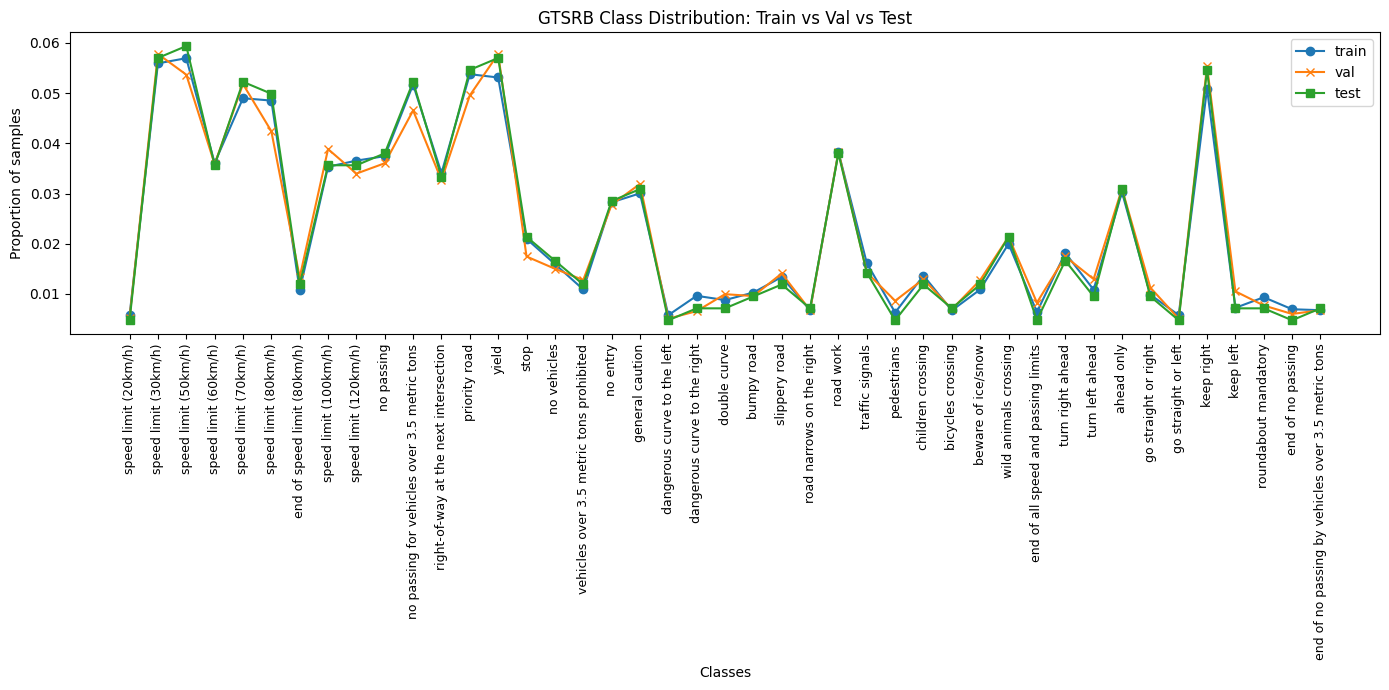

In [6]:
def counts_from_indices(indices):
    cnt = Counter(all_train_labels[i] for i in indices)
    return [cnt[i] for i in range(num_classes_GTSRB)]

train_counts = counts_from_indices(train_ds_GTSRB.indices)
val_counts   = counts_from_indices(val_ds_GTSRB.indices)

# load TEST set & count directly 
test_ds_GTSRB = GTSRB(root=data_dir_GTSRB, split="test", transform=None, download=False)
all_test_labels = [label for _, label in test_ds_GTSRB._samples]
test_counter    = Counter(all_test_labels)
test_counts     = [test_counter[i] for i in range(num_classes_GTSRB)]

# normalize to proportions 
train_total = sum(train_counts)
val_total   = sum(val_counts)
test_total  = sum(test_counts)

train_props = [c / train_total for c in train_counts]
val_props   = [c / val_total   for c in val_counts]
test_props  = [c / test_total  for c in test_counts]

# plot normalized distributions 
plt.figure(figsize=(14, 7))
x = range(num_classes_GTSRB)

plt.plot(x, train_props, marker='o', label="train")
plt.plot(x, val_props,   marker='x', label="val")
plt.plot(x, test_props,  marker='s', label="test")

plt.xticks(x, class_names_GTSRB, rotation=90, fontsize=9)
plt.xlabel("Classes")
plt.ylabel("Proportion of samples")
plt.title("GTSRB Class Distribution: Train vs Val vs Test")
plt.legend()
plt.tight_layout()
plt.show()

The LISA dataset is loaded and preprocessed using data augmentation and normalization to improve model robustness and generalization.

**Note:**  
Set `download=True` the first time you run the code to automatically download the dataset and store it in the specified `root` directory.  
Once the dataset is saved locally, you can set `download=False` to avoid re-downloading it on subsequent runs.

In [7]:
# mean/std the author reports (https://github.com/AminJun/lisa)
mean_LISA = [0.4563, 0.4076, 0.3895]
std_LISA  = [0.2298, 0.2144, 0.2259]

data_dir_LISA = "./data/LISA"

# specify transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.Normalize(mean_LISA, std_LISA),
])
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean_LISA, std_LISA),
])

# load the datasets (same pattern as GTSRB)
full_train_LISA = LISA(root=data_dir_LISA, 
                       train=True,
                      transform=train_transform, 
                       download=False)
test_ds_LISA    = LISA(root=data_dir_LISA, 
                       train=False,
                      transform=val_test_transform, 
                       download=False)

# split training set into train + validation (80/20 split like GTSRB)
train_size = int(0.8 * len(full_train_LISA))
val_size   = len(full_train_LISA) - train_size
train_ds_LISA, val_ds_LISA = random_split(
    full_train_LISA, [train_size, val_size]
)

# create DataLoaders
batch_size = 64
train_loader_LISA = DataLoader(
    train_ds_LISA, 
    batch_size=batch_size,                  
    shuffle=True,  
    num_workers=4
)
val_loader_LISA   = DataLoader(val_ds_LISA,   
                               batch_size=batch_size,
                               shuffle=False, 
                               num_workers=4
)
test_loader_LISA  = DataLoader(test_ds_LISA,  
                               batch_size=batch_size,
                               shuffle=False, 
                               num_workers=4
)

class_names_LISA = full_train_LISA.classes
num_classes_LISA = len(class_names_LISA)
print(f"LISA Number of Classes:")
print(num_classes_LISA)
print(f"\nLISA Classes:")
print(class_names_LISA)

print(f"\nLISA Dataset splits:")
print(f"Training: {len(train_ds_LISA)} samples")
print(f"Validation: {len(val_ds_LISA)} samples")
print(f"Test: {len(test_ds_LISA)} samples")

LISA Number of Classes:
47

LISA Classes:
['stop', 'speedLimitUrdbl', 'speedLimit25', 'pedestrianCrossing', 'speedLimit35', 'turnLeft', 'slow', 'speedLimit15', 'speedLimit45', 'rightLaneMustTurn', 'signalAhead', 'keepRight', 'laneEnds', 'school', 'merge', 'addedLane', 'rampSpeedAdvisory40', 'rampSpeedAdvisory45', 'curveRight', 'speedLimit65', 'truckSpeedLimit55', 'thruMergeLeft', 'speedLimit30', 'stopAhead', 'yield', 'thruMergeRight', 'dip', 'schoolSpeedLimit25', 'thruTrafficMergeLeft', 'noRightTurn', 'rampSpeedAdvisory35', 'curveLeft', 'rampSpeedAdvisory20', 'noLeftTurn', 'zoneAhead25', 'zoneAhead45', 'doNotEnter', 'yieldAhead', 'roundabout', 'turnRight', 'speedLimit50', 'rampSpeedAdvisoryUrdbl', 'rampSpeedAdvisory50', 'speedLimit40', 'speedLimit55', 'doNotPass', 'intersection']

LISA Dataset splits:
Training: 5296 samples
Validation: 1325 samples
Test: 1234 samples


The normalized class distribution across the LISA training, validation, and test splits is computed to assess the representation of each class within the dataset subsets.  
This analysis highlights potential class imbalances that may influence model performance. The results are visualized for clear comparison.

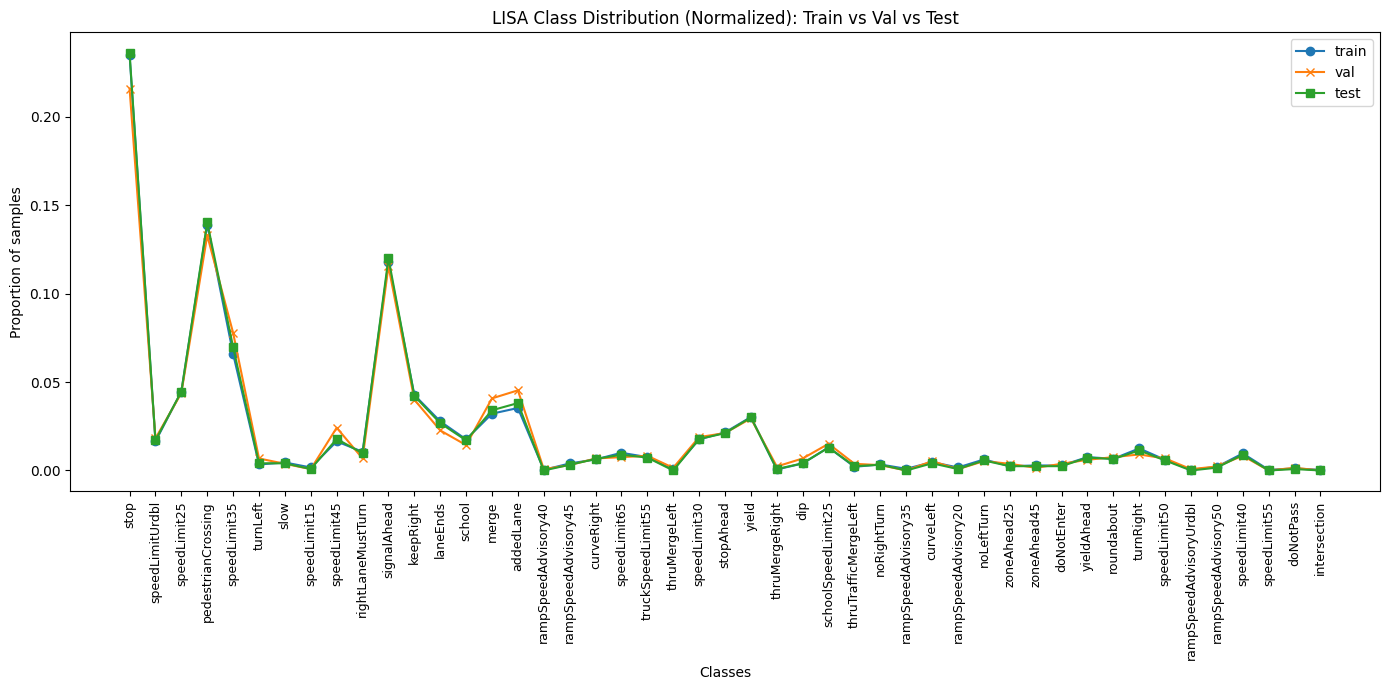

In [8]:
def get_counts_from_loader(loader):
    cnt = Counter()
    for _, labels in loader:
        for l in labels:
            cnt[int(l)] += 1
    return [cnt[i] for i in range(num_classes_LISA)]

train_counts = get_counts_from_loader(train_loader_LISA)
val_counts   = get_counts_from_loader(val_loader_LISA)
test_counts  = get_counts_from_loader(test_loader_LISA)

# normalize to proportions 
train_total = sum(train_counts)
val_total   = sum(val_counts)
test_total  = sum(test_counts)

train_props = [c / train_total for c in train_counts]
val_props   = [c / val_total   for c in val_counts]
test_props  = [c / test_total  for c in test_counts]

# plot normalized distributions 
plt.figure(figsize=(14, 7))
x = range(num_classes_LISA)
plt.plot(x, train_props, marker='o', label="train")
plt.plot(x, val_props,   marker='x', label="val")
plt.plot(x, test_props,  marker='s', label="test")

plt.xticks(x, class_names_LISA, rotation=90, fontsize=9)
plt.xlabel("Classes")
plt.ylabel("Proportion of samples")
plt.title("LISA Class Distribution (Normalized): Train vs Val vs Test")
plt.legend()
plt.tight_layout()
plt.show()

Training hyperparameters such as the learning rate and number of epochs are defined to configure the training process.  
Additionally, the number of target classes is determined from the dataset labels, which is required to properly configure the final classification layer of the model.

In [9]:
# hyper-params & device
learning_rate = 1e-4
num_epochs    = 10

num_classes_GTSRB = len(class_names_GTSRB)
print(num_classes_GTSRB)

43


A ResNet-50 model pre-trained on ImageNet is fine-tuned on the GTSRB dataset to adapt the learned representations to the target task.  
During training, validation accuracy is monitored to identify the best-performing model, which is saved for later evaluation and deployment.

In [10]:
# model init
model_GTSRB = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model_GTSRB.fc = nn.Linear(model_GTSRB.fc.in_features, num_classes_GTSRB)
model_GTSRB = model_GTSRB.to(device)

# loss, optimizer, best-model tracking
criterion_GTSRB      = nn.CrossEntropyLoss()
optimizer_GTSRB      = optim.Adam(model_GTSRB.parameters(), lr=learning_rate)
best_acc_GTSRB       = 0.0
best_epoch_GTSRB     = 0
best_wts_GTSRB       = copy.deepcopy(model_GTSRB.state_dict())

# training loop
for epoch in range(1, num_epochs+1):
    model_GTSRB.train()
    running_loss = 0.0
    # train on train_loader 
    for imgs, labels in train_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_GTSRB.zero_grad()
        out = model_GTSRB(imgs)
        loss = criterion_GTSRB(out, labels)
        loss.backward()
        optimizer_GTSRB.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader_GTSRB.dataset)

    # validate on val_loader
    model_GTSRB.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader_GTSRB:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model_GTSRB(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
    val_acc = correct / len(val_loader_GTSRB.dataset)

    # keep best
    if val_acc > best_acc_GTSRB:
        best_acc_GTSRB   = val_acc
        best_epoch_GTSRB = epoch
        best_wts_GTSRB   = copy.deepcopy(model_GTSRB.state_dict())

    print(f"[GTSRB] Epoch {epoch:2d}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

# final test‐set evaluation
model_GTSRB.load_state_dict(best_wts_GTSRB)
model_GTSRB.eval()
test_correct = 0
with torch.no_grad():
    for imgs, labels in test_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model_GTSRB(imgs).argmax(dim=1)
        test_correct += (preds == labels).sum().item()
test_acc = test_correct / len(test_loader_GTSRB.dataset)

print(f"\n[GTSRB] Best Val Epoch: {best_epoch_GTSRB} — Val Acc: {best_acc_GTSRB:.4f}")
print(f"[GTSRB] Final Test Acc: {test_acc:.4f}")

# save best weights
torch.save(best_wts_GTSRB, "./model/resnet50_gtsrb_100.pth")
print("[GTSRB] Saved best weights to ./model/resnet50_gtsrb_100.pth")

[GTSRB] Epoch  1/10 — Train Loss: 0.6799 — Val Acc: 0.9942
[GTSRB] Epoch  2/10 — Train Loss: 0.0232 — Val Acc: 0.9962
[GTSRB] Epoch  3/10 — Train Loss: 0.0148 — Val Acc: 0.9985
[GTSRB] Epoch  4/10 — Train Loss: 0.0112 — Val Acc: 0.9957
[GTSRB] Epoch  5/10 — Train Loss: 0.0069 — Val Acc: 0.9987
[GTSRB] Epoch  6/10 — Train Loss: 0.0022 — Val Acc: 0.9985
[GTSRB] Epoch  7/10 — Train Loss: 0.0092 — Val Acc: 0.9940
[GTSRB] Epoch  8/10 — Train Loss: 0.0067 — Val Acc: 0.9981
[GTSRB] Epoch  9/10 — Train Loss: 0.0130 — Val Acc: 0.9987
[GTSRB] Epoch 10/10 — Train Loss: 0.0049 — Val Acc: 0.9994

[GTSRB] Best Val Epoch: 10 — Val Acc: 0.9994
[GTSRB] Final Test Acc: 0.9834
[GTSRB] Saved best weights to ./model/resnet50_gtsrb_100.pth


An ImageNet-pretrained ResNet-50 model is trained on progressively larger subsets of the LISA training set, ranging from 1% to 100% of the available data.  
For each data fraction, validation is performed at every epoch to track performance and retain the best model weights.  
After training, each model is evaluated on the full LISA test set, and the best-performing model for each data regime is saved for further analysis.

In [11]:
fractions = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]

for frac in fractions:
    # sample a subset of the LISA training data
    n_total = len(full_train_LISA)
    n_sub   = int(frac * n_total)
    indices = np.random.choice(n_total, n_sub, replace=False)
    sub_ds  = Subset(full_train_LISA, indices)
    sub_loader = DataLoader(sub_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # initialize a fresh ResNet-50 for this fraction
    model_LISA = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model_LISA.fc = nn.Linear(model_LISA.fc.in_features, num_classes_LISA)
    model_LISA.to(device)
    
    # set up optimizer, loss, and best-tracking
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_LISA.parameters(), lr=learning_rate)
    best_acc  = 0.0
    best_wts  = copy.deepcopy(model_LISA.state_dict())
    
    # training loop on the subset
    for epoch in range(1, num_epochs+1):
        model_LISA.train()
        running_loss = 0.0
        for imgs, labels in sub_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_LISA(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        
        # validate on the full val set
        model_LISA.eval()
        correct = 0
        with torch.no_grad():
            for imgs, labels in val_loader_LISA:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model_LISA(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_acc = correct / len(val_loader_LISA.dataset)
        
        # track best
        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = copy.deepcopy(model_LISA.state_dict())
        
        print(f"[LISA {int(frac*100)}%] Epoch {epoch}/{num_epochs} — Val Acc: {val_acc:.4f}")
    
    # test‐set evaluation with best weights
    model_LISA.load_state_dict(best_wts)
    model_LISA.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader_LISA:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model_LISA(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
    test_acc = correct / len(test_loader_LISA.dataset)
    print(f"[LISA {int(frac*100)}%] Test Acc: {test_acc:.4f}")
    
    # save the best‐performing weights
    out_path = f"./model/resnet50_lisa_{int(frac*100)}.pth"
    torch.save(best_wts, out_path)
    print(f"Saved best weights for {int(frac*100)}% subset to {out_path}\n")

[LISA 1%] Epoch 1/10 — Val Acc: 0.0506
[LISA 1%] Epoch 2/10 — Val Acc: 0.0687
[LISA 1%] Epoch 3/10 — Val Acc: 0.1034
[LISA 1%] Epoch 4/10 — Val Acc: 0.1472
[LISA 1%] Epoch 5/10 — Val Acc: 0.1706
[LISA 1%] Epoch 6/10 — Val Acc: 0.1992
[LISA 1%] Epoch 7/10 — Val Acc: 0.2204
[LISA 1%] Epoch 8/10 — Val Acc: 0.2732
[LISA 1%] Epoch 9/10 — Val Acc: 0.2958
[LISA 1%] Epoch 10/10 — Val Acc: 0.3147
[LISA 1%] Test Acc: 0.2123
Saved best weights for 1% subset to ./model/resnet50_lisa_1.pth

[LISA 5%] Epoch 1/10 — Val Acc: 0.2642
[LISA 5%] Epoch 2/10 — Val Acc: 0.3223
[LISA 5%] Epoch 3/10 — Val Acc: 0.3826
[LISA 5%] Epoch 4/10 — Val Acc: 0.4294
[LISA 5%] Epoch 5/10 — Val Acc: 0.4611
[LISA 5%] Epoch 6/10 — Val Acc: 0.4792
[LISA 5%] Epoch 7/10 — Val Acc: 0.4951
[LISA 5%] Epoch 8/10 — Val Acc: 0.5389
[LISA 5%] Epoch 9/10 — Val Acc: 0.5743
[LISA 5%] Epoch 10/10 — Val Acc: 0.6181
[LISA 5%] Test Acc: 0.5559
Saved best weights for 5% subset to ./model/resnet50_lisa_5.pth

[LISA 10%] Epoch 1/10 — Val Acc: 0

The fine-tuned ResNet-50 model trained on the GTSRB dataset is loaded to evaluate its performance on the test set.  
Correct predictions and the most confident incorrect predictions are identified based on model confidence scores.  
Representative examples from both categories are displayed side-by-side to enable visual inspection and qualitative assessment of model behavior.

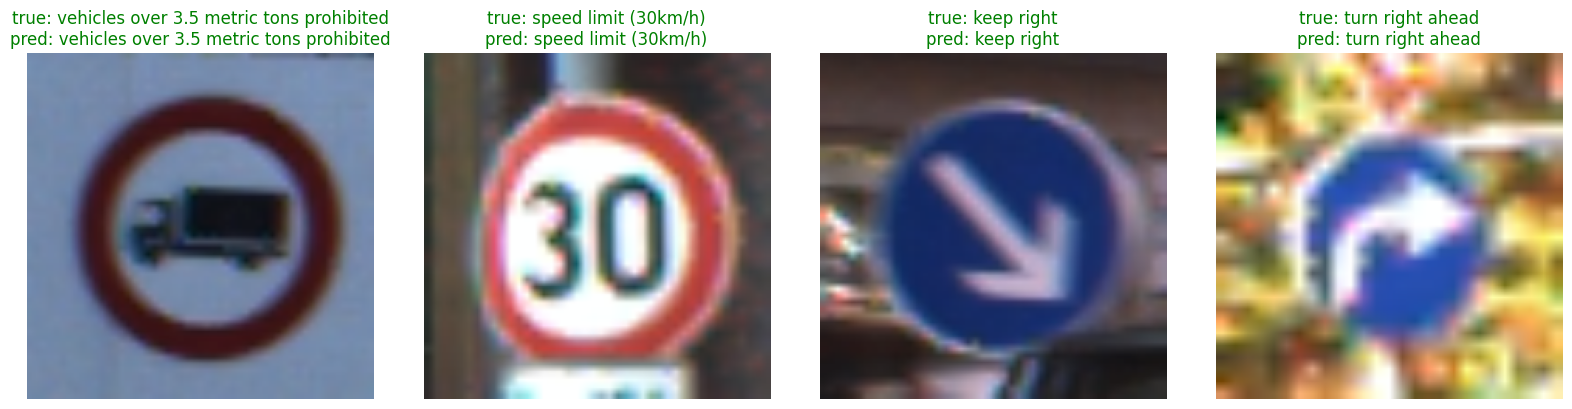

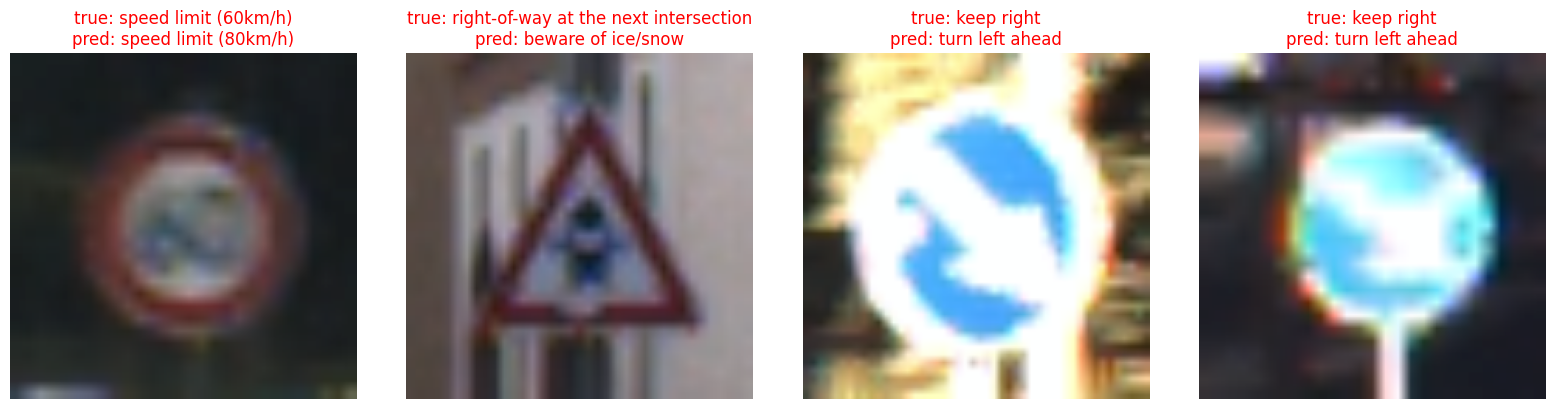

In [12]:
# load fine-trained model
model_GTSRB = resnet50(weights=None)
model_GTSRB.fc = torch.nn.Linear(model_GTSRB.fc.in_features, num_classes_GTSRB)
model_GTSRB.load_state_dict(
    torch.load("./model/resnet50_gtsrb_100.pth", map_location=device)
)
model_GTSRB.to(device).eval()

# helpers
def find_confident_wrong_predictions(model, loader, device, target=4):
    buff = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)
            preds = out.argmax(1)
            for i in range(len(imgs)):
                if preds[i] != labels[i]:
                    buff.append((
                        imgs[i].cpu(), 
                        labels[i].item(), 
                        preds[i].item(), 
                        probs[i, preds[i]].item()
                    ))
    buff.sort(key=lambda x: x[3], reverse=True)
    # strip confidence, return only img, true, pred
    return [(img, tl, pr) for img, tl, pr, _ in buff[:target]]

def find_correct_predictions(model, loader, device, target=4):
    correct = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            for i in range(len(imgs)):
                if preds[i] == labels[i]:
                    correct.append((imgs[i].cpu(), labels[i].item(), preds[i].item()))
                    if len(correct) >= target:
                        return correct
    return correct

# data transforms & loaders
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds  = GTSRB(root="./data/GTSRB", split="test",  transform=val_transform, download=False)
train_ds = GTSRB(root="./data/GTSRB", split="train", transform=val_transform, download=False)
train_size = int(0.8 * len(train_ds))
_, val_ds  = random_split(train_ds, [train_size, len(train_ds) - train_size])

test_loader = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=4)
val_loader  = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=4)

# get sample sets
incorrect = find_confident_wrong_predictions(model_GTSRB, test_loader, device)
correct   = find_correct_predictions(model_GTSRB, test_loader, device)

# un-normalizer
inv_mean = np.array(mean)
inv_std  = np.array(std)

def visualize_batch(samples, color):
    plt.figure(figsize=(16, 4))
    for i, (img_t, true_lbl, pred_lbl) in enumerate(samples):
        img = img_t.permute(1, 2, 0).numpy()
        img = img * inv_std[None, None, :] + inv_mean[None, None, :]
        img = np.clip(img, 0, 1)
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(img)
        plt.title(f"true: {class_names_GTSRB[true_lbl]}\npred: {class_names_GTSRB[pred_lbl]}",
                  color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# plot
if correct:
    visualize_batch(correct, "green")
if incorrect:
    visualize_batch(incorrect, "red")

The fine-tuned ResNet-50 model trained on the LISA dataset is loaded for evaluation on the test set.  
Correctly classified examples and the most confident misclassifications are identified using the model's prediction probabilities.  
Selected instances from each category are displayed side-by-side to facilitate visual inspection and qualitative analysis of model performance.

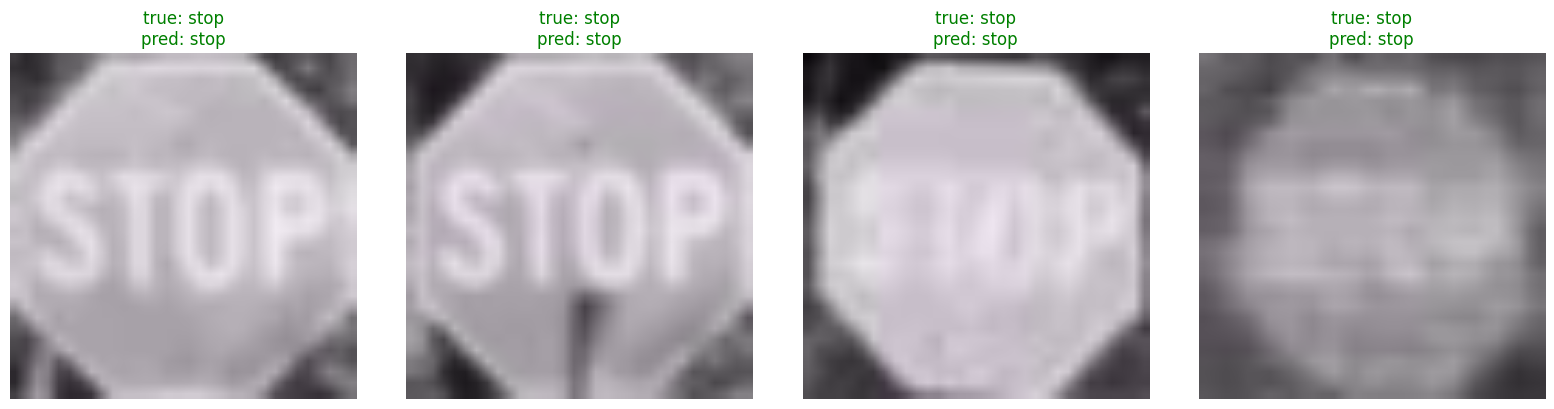

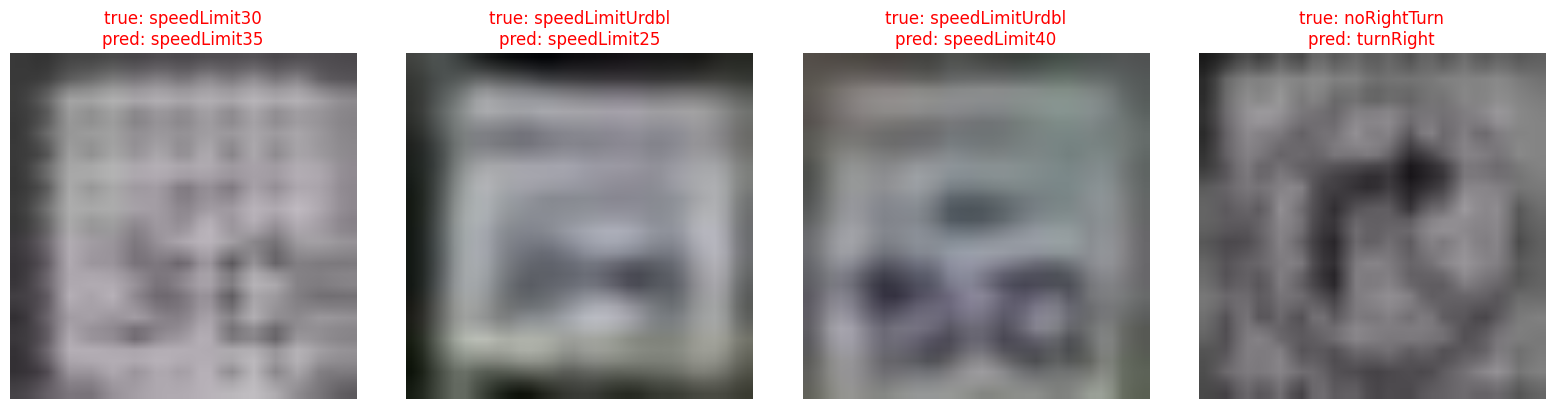

In [13]:
# load fine-tuned LISA model
model_LISA = resnet50(weights=None)
model_LISA.fc = nn.Linear(model_LISA.fc.in_features, num_classes_LISA)
model_LISA.load_state_dict(torch.load("./model/resnet50_lisa_100.pth", map_location=device))
model_LISA.to(device).eval()

# helpers: find confident wrong and correct predictions
def find_confident_wrong_predictions(model, loader, device, target=4):
    buff = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)
            preds = out.argmax(1)
            for i in range(len(imgs)):
                if preds[i] != labels[i]:
                    buff.append((imgs[i].cpu(),
                                 labels[i].item(),
                                 preds[i].item(),
                                 probs[i, preds[i]].item()))
    buff.sort(key=lambda x: x[3], reverse=True)
    return [(img, tl, pr) for img, tl, pr, _ in buff[:target]]

def find_correct_predictions(model, loader, device, target=4):
    correct = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            for i in range(len(imgs)):
                if preds[i] == labels[i]:
                    correct.append((imgs[i].cpu(), labels[i].item(), preds[i].item()))
                    if len(correct) >= target:
                        return correct
    return correct

# LISA dataset transforms & loaders
mean_LISA = [0.4563, 0.4076, 0.3895]
std_LISA  = [0.2298, 0.2144, 0.2259]

val_transform_LISA = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean_LISA, std_LISA),
])

test_ds_LISA  = LISA(root="./data/LISA", train=False, transform=val_transform_LISA, download=False)
train_ds_LISA = LISA(root="./data/LISA", train=True, transform=val_transform_LISA, download=False)
train_size = int(0.8 * len(train_ds_LISA))
_, val_ds_LISA = random_split(train_ds_LISA, [train_size, len(train_ds_LISA) - train_size])

test_loader_LISA = DataLoader(test_ds_LISA,  batch_size=64, shuffle=False, num_workers=4)
val_loader_LISA  = DataLoader(val_ds_LISA, batch_size=64, shuffle=False, num_workers=4)

# retrieve samples
incorrect_LISA = find_confident_wrong_predictions(model_LISA, test_loader_LISA, device)
correct_LISA   = find_correct_predictions(model_LISA, test_loader_LISA, device)

# un-normalizer for visualization
inv_mean_LISA = np.array(mean_LISA)
inv_std_LISA  = np.array(std_LISA)

def visualize_batch(samples, color):
    plt.figure(figsize=(16, 4))
    for i, (img_t, true_lbl, pred_lbl) in enumerate(samples):
        img = img_t.permute(1, 2, 0).numpy()
        img = img * inv_std_LISA[None, None, :] + inv_mean_LISA[None, None, :]
        img = np.clip(img, 0, 1)
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(img)
        plt.title(f"true: {class_names_LISA[true_lbl]}\npred: {class_names_LISA[pred_lbl]}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# plot correct (green) and incorrect (red)
if correct_LISA:
    visualize_batch(correct_LISA, "green")
if incorrect_LISA:
    visualize_batch(incorrect_LISA, "red")

Only the final fully-connected layer of the ResNet-50 model, pre-trained and fine-tuned on GTSRB, is further fine-tuned on varying fractions of the LISA training set.  
For each data fraction, validation accuracy is monitored across epochs to determine and save the best-performing model.  
The selected model for each fraction is then evaluated on the complete LISA test set, and the corresponding weights are stored for later analysis.

In [16]:
# load pretrained GTSRB backbone 
GTSRB_model = resnet50(weights=None)
GTSRB_model.fc = nn.Linear(GTSRB_model.fc.in_features, num_classes_GTSRB)
GTSRB_model.load_state_dict(
    torch.load("./model/resnet50_gtsrb_100.pth", map_location=device)
)
GTSRB_model.to(device)

# head‐only transfer learning, tracking best epoch 
fractions = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
transfer_results = {}

for frac in fractions:
    # subset LISA train
    n_total = len(full_train_LISA)
    n_sub   = int(frac * n_total)
    idxs    = np.random.choice(n_total, n_sub, replace=False)
    sub_ds  = Subset(full_train_LISA, idxs)
    sub_loader = DataLoader(sub_ds, batch_size=batch_size,
                            shuffle=True, num_workers=4)
    
    # clone & re-head
    model_LISA_transfer = copy.deepcopy(GTSRB_model)
    model_LISA_transfer.fc = nn.Linear(model_LISA_transfer.fc.in_features, num_classes_LISA)
    model_LISA_transfer.to(device)
    
    # freeze all but head
    for name, param in model_LISA_transfer.named_parameters():
        param.requires_grad = name.startswith("fc.")
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_LISA_transfer.parameters()),
                           lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # best-tracking vars
    best_acc = 0.0
    best_epoch = 0
    best_wts = copy.deepcopy(model_LISA_transfer.state_dict())
    
    # train loop (validate on LISA val_loader_LISA each epoch)
    for epoch in range(1, num_epochs + 1):
        model_LISA_transfer.train()
        for imgs, labels in sub_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model_LISA_transfer(imgs), labels)
            loss.backward()
            optimizer.step()
        
        # validation
        model_LISA_transfer.eval()
        correct = 0
        with torch.no_grad():
            for imgs, labels in val_loader_LISA:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model_LISA_transfer(imgs).argmax(1)
                correct += (preds == labels).sum().item()
        val_acc = correct / len(val_loader_LISA.dataset)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            best_wts = copy.deepcopy(model_LISA_transfer.state_dict())
        
        print(f"[Transfer GTSRB -> LISA {int(frac*100)}%] Epoch {epoch}/{num_epochs} — Val Acc: {val_acc:.4f}")
    
    # test-set eval with best weights
    model_LISA_transfer.load_state_dict(best_wts)
    model_LISA_transfer.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader_LISA:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model_LISA_transfer(imgs).argmax(1)
            correct += (preds == labels).sum().item()
    test_acc = correct / len(test_loader_LISA.dataset)
    
    # record & save
    transfer_results[frac] = test_acc
    print(f"[Transfer GTSRB -> LISA {int(frac*100)}%] Best Epoch: {best_epoch} — Test Acc: {test_acc:.4f}")
    
    torch.save(best_wts, f"./model/resnet50_lisa_transfer_{int(frac*100)}.pth")
    print(f"Saved best weights (epoch {best_epoch}) to resnet50_lisa_transfer_{int(frac*100)}.pth\n")

[Transfer GTSRB -> LISA 1%] Epoch 1/10 — Val Acc: 0.0460
[Transfer GTSRB -> LISA 1%] Epoch 2/10 — Val Acc: 0.0777
[Transfer GTSRB -> LISA 1%] Epoch 3/10 — Val Acc: 0.1170
[Transfer GTSRB -> LISA 1%] Epoch 4/10 — Val Acc: 0.1464
[Transfer GTSRB -> LISA 1%] Epoch 5/10 — Val Acc: 0.1842
[Transfer GTSRB -> LISA 1%] Epoch 6/10 — Val Acc: 0.2098
[Transfer GTSRB -> LISA 1%] Epoch 7/10 — Val Acc: 0.2264
[Transfer GTSRB -> LISA 1%] Epoch 8/10 — Val Acc: 0.2325
[Transfer GTSRB -> LISA 1%] Epoch 9/10 — Val Acc: 0.2460
[Transfer GTSRB -> LISA 1%] Epoch 10/10 — Val Acc: 0.2604
[Transfer GTSRB -> LISA 1%] Best Epoch: 10 — Test Acc: 0.2391
Saved best weights (epoch 10) to resnet50_lisa_transfer_1.pth

[Transfer GTSRB -> LISA 5%] Epoch 1/10 — Val Acc: 0.1192
[Transfer GTSRB -> LISA 5%] Epoch 2/10 — Val Acc: 0.1849
[Transfer GTSRB -> LISA 5%] Epoch 3/10 — Val Acc: 0.2536
[Transfer GTSRB -> LISA 5%] Epoch 4/10 — Val Acc: 0.3253
[Transfer GTSRB -> LISA 5%] Epoch 5/10 — Val Acc: 0.4325
[Transfer GTSRB -> 

The test-set accuracy of two ResNet-50 models is computed and compared across varying fractions of the LISA training data:  
(1) a scratch-trained model ("LISA Base") and  
(2) a model fine-tuned via transfer learning from a GTSRB-pretrained backbone ("LISA Transfer").  
Accuracy values are recorded for each fraction, and performance curves are plotted to visualize and assess the impact of transfer learning relative to training from scratch.

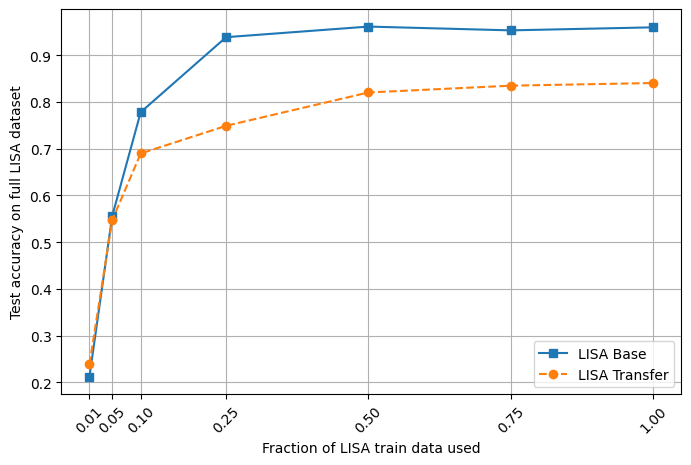

In [20]:
# fractions (in percent)
fracs = [1, 5, 10, 25, 50, 75, 100]

scratch_acc   = {}
transfer_acc  = {}

for p in fracs:
    # LISA model checkpoint
    m_s = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    m_s.fc = nn.Linear(m_s.fc.in_features, num_classes_LISA)
    ckpt_s = f"./model/resnet50_lisa_{p}.pth"
    m_s.load_state_dict(torch.load(ckpt_s, map_location=device))
    m_s.to(device).eval()
    
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader_LISA:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = m_s(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    scratch_acc[p] = correct/total
    
    # LISA transfer model checkpoint 
    m_t = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    m_t.fc = nn.Linear(m_t.fc.in_features, num_classes_LISA)
    ckpt_t = f"./model/resnet50_lisa_transfer_{p}.pth"
    m_t.load_state_dict(torch.load(ckpt_t, map_location=device))
    m_t.to(device).eval()
    
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader_LISA:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = m_t(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    transfer_acc[p] = correct/total

# plot both curves 
xs = [p / 100 for p in fracs]
ys_s = [scratch_acc[p] for p in fracs]
ys_t = [transfer_acc[p] for p in fracs]

plt.figure(figsize=(8,5))
plt.plot(xs, ys_s, marker='s', linestyle='-', label="LISA Base")
plt.plot(xs, ys_t, marker='o', linestyle='--', label="LISA Transfer")
plt.xticks(xs, [f"{x:.2f}" for x in xs], rotation=45)
plt.xlabel("Fraction of LISA train data used")
plt.ylabel("Test accuracy on full LISA dataset")
plt.legend()
plt.grid(True)
plt.show()

Per-class test accuracy is computed for both the scratch-trained (“LISA Base”) and GTSRB-transfer (“LISA Transfer”) ResNet-50 models at each training data fraction.  
These per-class accuracies are visualized as side-by-side heatmaps to enable comparison across classes.  
An additional heatmap shows the difference in accuracy between the transfer and base models, highlighting where transfer learning provides the most benefit.

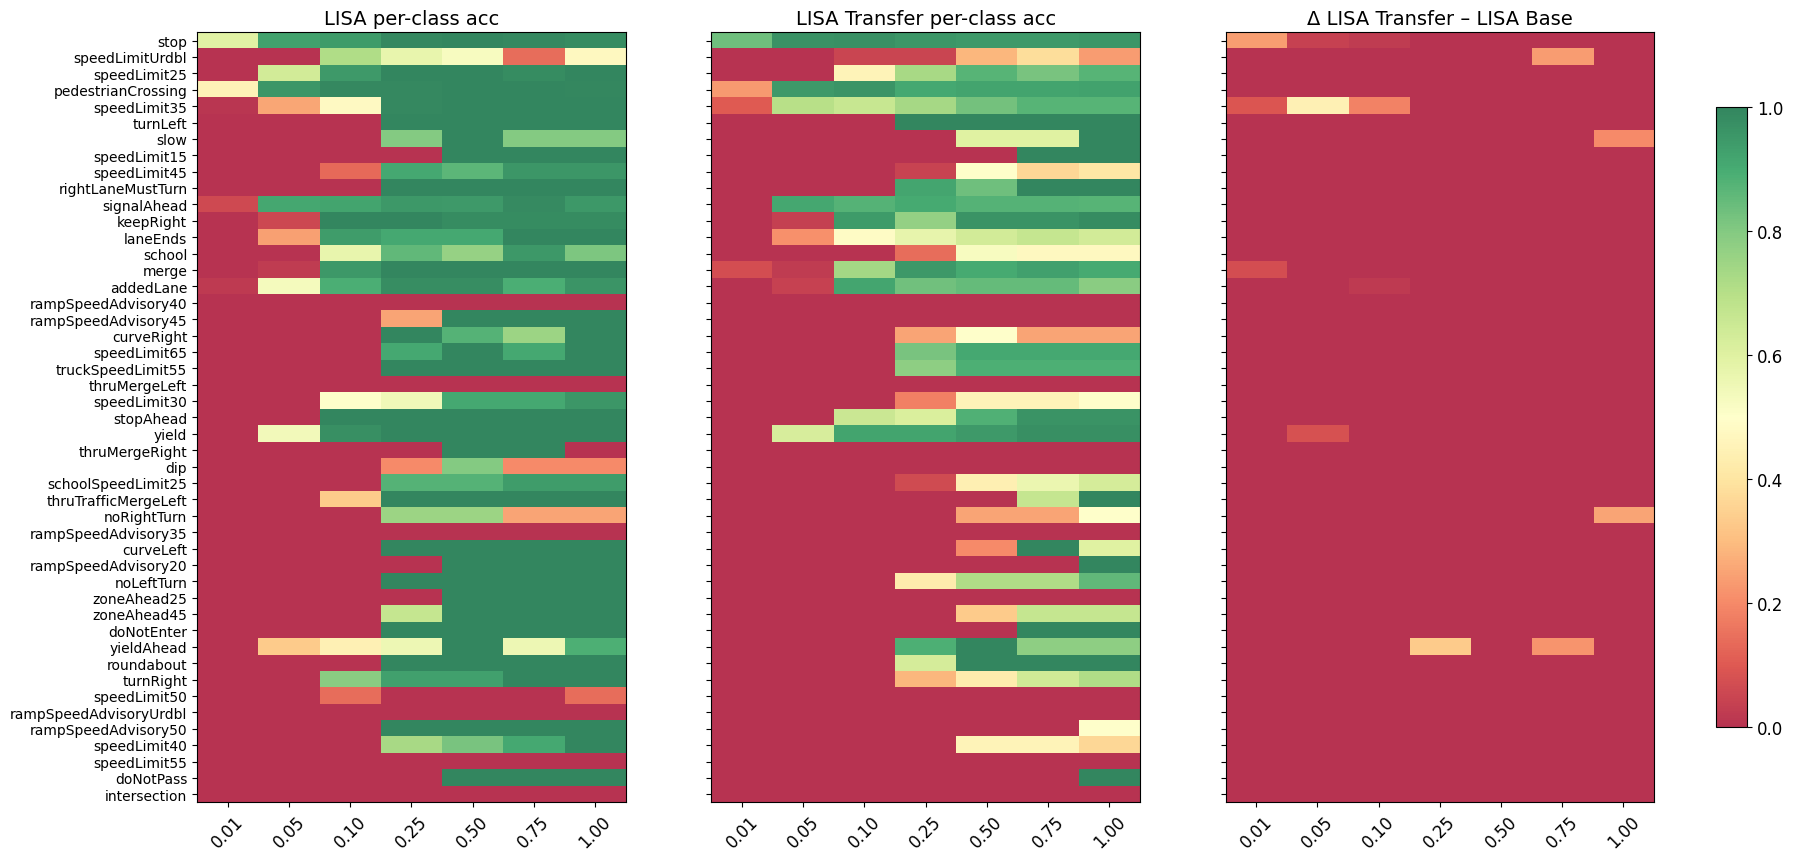

In [18]:
# configuration from your notebook
fracs        = [1, 5, 10, 25, 50, 75, 100] # in percent
frac_vals = [p / 100 for p in fracs]

# allocate storage
scratch_acc   = {p: np.zeros(num_classes_LISA) for p in fracs}
transfer_acc  = {p: np.zeros(num_classes_LISA) for p in fracs}
counts        = np.zeros(num_classes_LISA, dtype=int)

# first, compute `counts` once: how many test samples per class
for _, labels in test_loader_LISA:
    for lbl in labels.numpy():
        counts[lbl] += 1

# loop fractions, load checkpoints, tally per-class correct
for p in fracs:
    # load scratch model
    m_s = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    m_s.fc = nn.Linear(m_s.fc.in_features, num_classes_LISA)
    m_s.load_state_dict(torch.load(f"./model/resnet50_lisa_{p}.pth", map_location=device))
    m_s.to(device).eval()
    # load transfer model
    m_t = resnet50(weights=None)
    m_t.fc = nn.Linear(m_t.fc.in_features, num_classes_LISA)
    m_t.load_state_dict(torch.load(f"./model/resnet50_lisa_transfer_{p}.pth", map_location=device))
    m_t.to(device).eval()

    # per-class correct counters
    corr_s = np.zeros(num_classes_LISA, dtype=int)
    corr_t = np.zeros(num_classes_LISA, dtype=int)

    with torch.no_grad():
        for imgs, labels in test_loader_LISA:
            imgs, labels = imgs.to(device), labels.to(device)
            ps = m_s(imgs).argmax(1).cpu().numpy()
            pt = m_t(imgs).argmax(1).cpu().numpy()
            lbl = labels.cpu().numpy()
            for i in range(len(lbl)):
                corr_s[lbl[i]] += (ps[i] == lbl[i])
                corr_t[lbl[i]] += (pt[i] == lbl[i])

    # avoid division-by-zero
    scratch_acc[p] = np.divide(
        corr_s, counts,
        out=np.zeros_like(corr_s, dtype=float),
        where=counts != 0
    )
    transfer_acc[p] = np.divide(
        corr_t, counts,
        out=np.zeros_like(corr_t, dtype=float),
        where=counts != 0
    )

# build DataFrames
scratch_df  = pd.DataFrame(scratch_acc, index=class_names_LISA)
transfer_df = pd.DataFrame(transfer_acc, index=class_names_LISA)
diff_df     = transfer_df - scratch_df

# plot three heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

cmaps = ["RdYlGn", "RdYlGn", "RdYlGn"]
titles = ["LISA per-class acc", "LISA Transfer per-class acc", "Δ LISA Transfer – LISA Base"]
dfs    = [scratch_df, transfer_df, diff_df]

for ax, df, cmap, title in zip(axes, dfs, cmaps, titles):
    im = ax.imshow(df.values, aspect='auto', vmin=0, vmax=1, cmap=cmap, alpha=0.8)
    ax.set_xticks(range(len(frac_vals)))
    ax.set_xticklabels([f"{v:.2f}" for v in frac_vals], rotation=45, fontsize=12)
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=10)
    ax.set_title(title, fontsize=14)

# shared colorbar on the right
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=12)
plt.show()
